In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, signal
import pickle

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,UpSampling2D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras import models,Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets
import time

%matplotlib inline

In [2]:
# to load the resized data
pickle_in = open("training_data_100px.pickle",'rb')
training_data = pickle.load(pickle_in)


In [3]:
training_data = training_data.astype('float32')/255.

In [4]:
X_train,X_valid,Y_train_ground_truth,Y_valid_ground_truth = train_test_split(training_data,training_data,test_size = 0.20)

In [5]:
X_train.shape, X_valid.shape

((2200, 100, 100, 3), (550, 100, 100, 3))

##### Adding noise to the original image

In [6]:
noise_factor = 0.6
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

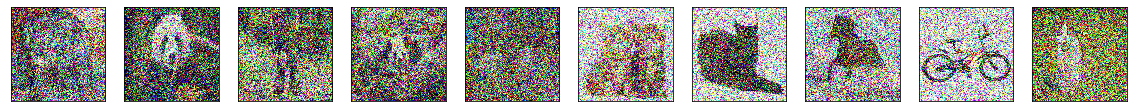

In [7]:
num_images = 10

random_test_image_ind = np.random.randint(X_valid.shape[0], size=num_images)

plt.figure(figsize=(20, 2))

for i,image_index in enumerate(random_test_image_ind):
    ax = plt.subplot(1, num_images, i+1)
    plt.imshow(x_test_noisy[image_index].reshape(100, 100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##### Model

In [8]:
input_img = Input(shape=(100, 100, 3))

encoder1 = Conv2D(64, (3, 3), padding='same')(input_img)
encoder2 = BatchNormalization()(encoder1)
encoder3 = Activation('relu')(encoder2)
encoder4 = MaxPooling2D((2, 2), padding='same')(encoder3)
encoder5 = Conv2D(32, (3, 3), padding='same')(encoder4)
encoder6 = BatchNormalization()(encoder5)
encoder7 = Activation('relu')(encoder6)
encoder8 = MaxPooling2D((2, 2), padding='same')(encoder7)
encoder9 = Conv2D(16, (3, 3), padding='same')(encoder8)
encoder10 = BatchNormalization()(encoder9)
encoder11 = Activation('relu')(encoder10)

encoded = MaxPooling2D((1, 1), padding='same',name='Compressed')(encoder11)

decoder1 = Conv2D(16, (3, 3), padding='same')(encoded)
decoder2 = BatchNormalization()(decoder1)
decoder3 = Activation('relu')(decoder2)
decoder4 = UpSampling2D((2, 2))(decoder3)
decoder5 = Conv2D(32, (3, 3), padding='same')(decoder4)
decoder6 = BatchNormalization()(decoder5)
decoder7 = Activation('relu')(decoder6)
decoder8 = UpSampling2D((2, 2))(decoder7)
decoder9 = Conv2D(64, (3, 3), padding='same')(decoder8)
decoder10 = BatchNormalization()(decoder9)
decoder11 = Activation('relu')(decoder10)
decoder12 = Conv2D(3, (3, 3), padding='same')(decoder11)
decoder13 = BatchNormalization()(decoder12)

decoded = Activation('sigmoid')(decoder13)

W0908 02:34:20.562769 15208 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
self_model = Model(input_img, decoded)
self_model.compile(optimizer='adam', loss='binary_crossentropy')

W0908 02:34:21.285462 15208 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


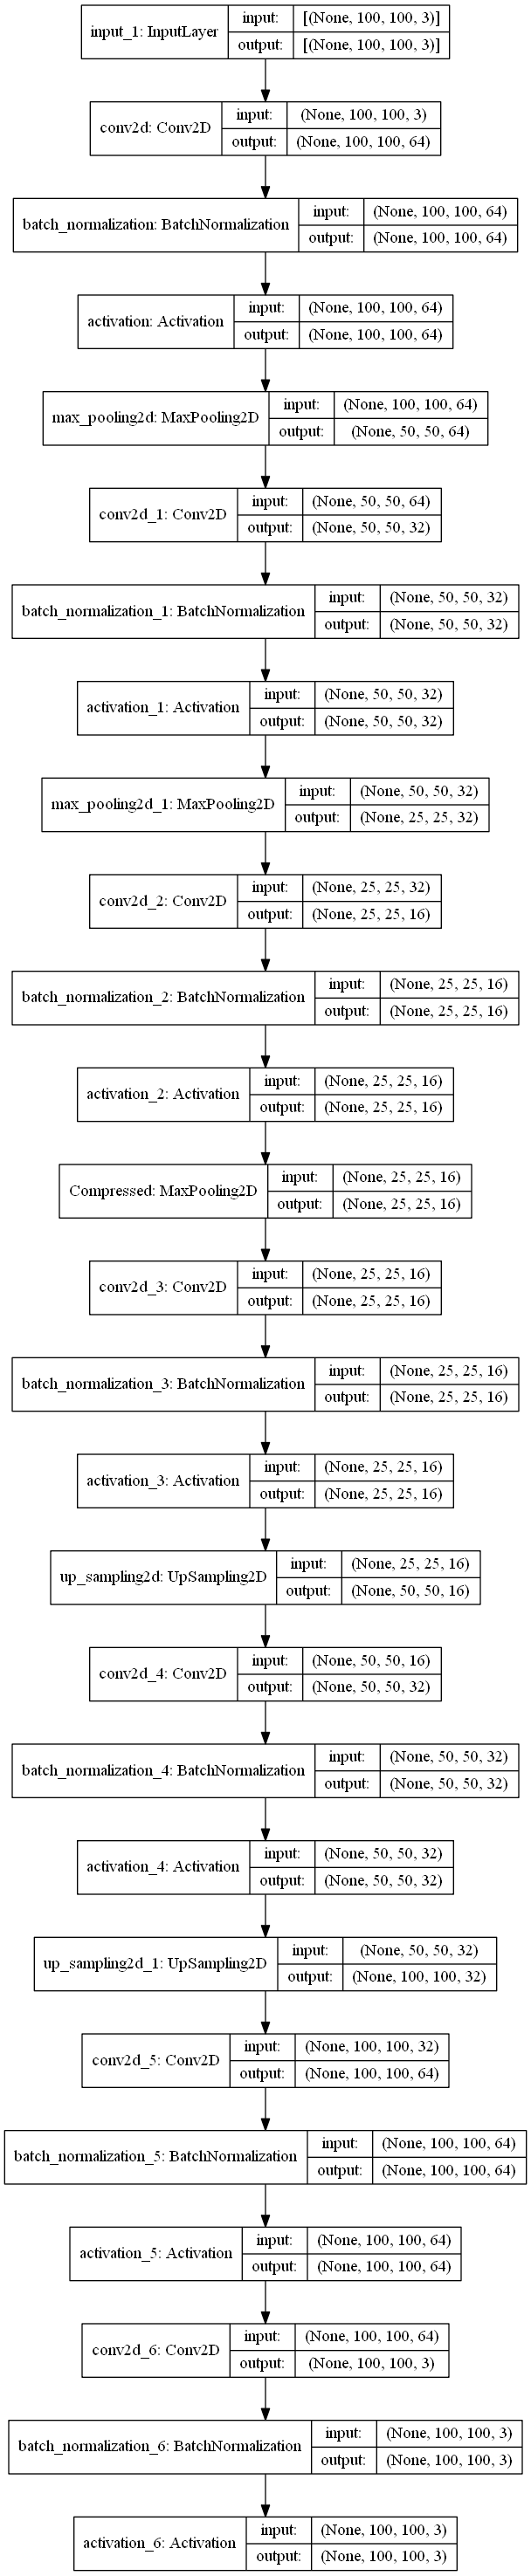

In [10]:
plot_model(self_model, show_shapes=True)

In [11]:
early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0.01,
                                       patience=5,
                                       verbose=1, 
                                       mode='min')

In [12]:
history = self_model.fit(x_train_noisy, Y_train_ground_truth,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test_noisy, Y_valid_ground_truth),
                    shuffle=True,
                    callbacks=[early_stopping])

Train on 2200 samples, validate on 550 samples
Epoch 1/50
2200/2200 [==============================] - 42s 19ms/sample - loss: 0.5524 - val_loss: 0.7064
Epoch 2/50
2200/2200 [==============================] - 34s 15ms/sample - loss: 0.5311 - val_loss: 0.5709
Epoch 3/50
2200/2200 [==============================] - 34s 15ms/sample - loss: 0.5247 - val_loss: 0.5518
Epoch 4/50
2200/2200 [==============================] - 34s 15ms/sample - loss: 0.5208 - val_loss: 0.5358
Epoch 5/50
2200/2200 [==============================] - 34s 15ms/sample - loss: 0.5182 - val_loss: 0.5274
Epoch 6/50
2200/2200 [==============================] - 34s 15ms/sample - loss: 0.5157 - val_loss: 0.5203
Epoch 7/50
2200/2200 [==============================] - 33s 15ms/sample - loss: 0.5142 - val_loss: 0.5237
Epoch 8/50
2200/2200 [==============================] - 34s 15ms/sample - loss: 0.5146 - val_loss: 0.5220
Epoch 9/50
2200/2200 [==============================] - 34s 16ms/sample - loss: 0.5117 - val_loss: 0.5288

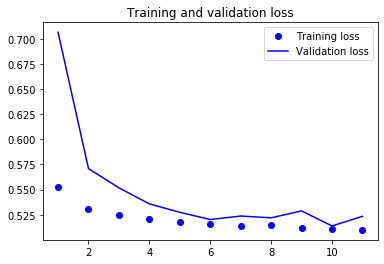

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
encoder_latent = Model(inputs = input_img, outputs = encoded)

encoded_imgs = encoder_latent.predict(X_valid)#compressed

decoded_imgs = self_model.predict(X_valid)#reconstructed

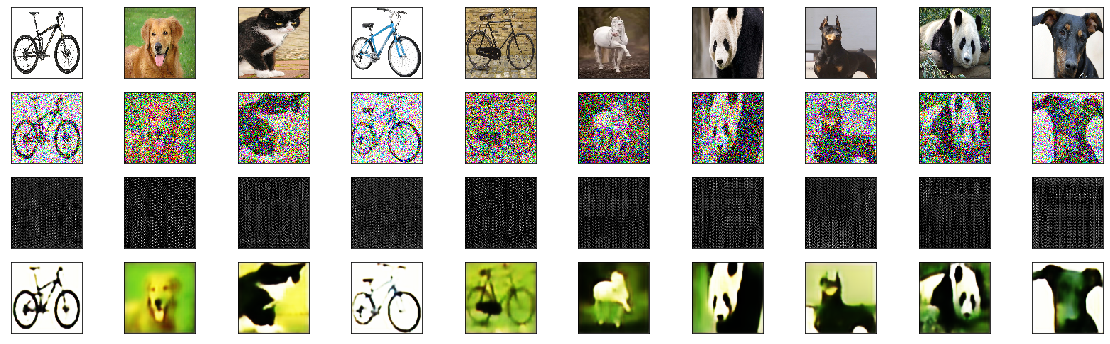

In [37]:
num_images = 10

random_test_image_ind = np.random.randint(X_valid.shape[0], size=num_images)

plt.figure(figsize=(20, 6))

for i,image_index in enumerate(random_test_image_ind):
    # display original
    ax = plt.subplot(4, num_images, i+1)
    plt.imshow(X_valid[image_index].reshape(100, 100,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy image
    ax = plt.subplot(4, num_images, i+num_images+1)
    plt.imshow(x_test_noisy[image_index].reshape(100, 100,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # compressed representation
    ax = plt.subplot(4, num_images, i+2*num_images+1)
    plt.imshow(encoded_imgs[image_index].reshape(100,100))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, num_images, i+3*num_images+1)
    plt.imshow(decoded_imgs[image_index].reshape(100, 100,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [38]:
#  free memory resources, it will interrupt the kernel
# os.kill(os.getpid(), signal.SIGTERM)